In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os
import tqdm
from collections import namedtuple

## Functions

In [3]:
def histoplot(var, xlabel, ylabel, bins=100, figsize=(4,4), title=""):
    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    h = plt.hist(var,bins)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    return h[0],h[1]

In [4]:
def prgroup(grdf, ng=1):
    i = 1
    for name, group in grdf:
        print(f"Group: {name}")
        print(group, "\n")
        i+=1
        if i > ng:
            break

In [5]:
def event_ekin(df):
    grdf = df.groupby('event_id')
    ekin = grdf['kin_energy'].sum()
    return ekin

In [6]:
def event_size(df):
    return len(np.unique(df.event_id))

In [7]:
def xindex(x,sx):
    return np.floor((x + xmin +dx)/sx)

def yindex(x, sy):
    return np.floor((x + ymin +dy)/sy)

def zindex(x, sz):
    return np.floor((x - zmin)/sz)


In [8]:
def voxelize(gdfx,mcrst,sx,sy,sz,ecut,case='pixel'):
    gdf = gdfx.copy()
    nx = int(mcrst.dx/sx)
    ny = int(mcrst.dy/sy)
    nz = int(mcrst.dz/sz)
    
    print(f"nx = {nx}, ny = {ny}, nz = {nz}")
    print(f"number of voxels = {nx*ny*nz}")
    print(f"index for xmin ={xindex(mcrst.xmin, sx)} index for xmax ={xindex(mcrst.xmax, sx)}")
    print(f"index for ymin ={yindex(mcrst.ymin, sy)} index for ymax ={yindex(mcrst.ymax, sy)}")
    print(f"index for zmin ={zindex(mcrst.zmin, sz)} index for zmax ={zindex(mcrst.zmax, sz)}")

    gdf["ix"]= xindex(gdf.final_x.values, sx).astype(int)
    gdf["iy"]= yindex(gdf.final_y.values, sy).astype(int)
    gdf["iz"]= zindex(gdf.final_z.values, sz).astype(int)

    if case == 'pixel':
        grdf = gdf.groupby(['event_id', 'ix', 'iy'])
    else:
         grdf = gdf.groupby(['event_id', 'ix', 'iy', 'iz'])

    gdf = grdf.agg(
                ebox = ('kin_energy', 'sum'),
                tbox = ('initial_t', 'mean'),     
                xbox = ('final_x', 'mean'),     
                ybox = ('final_y', 'mean'),        
                zbox = ('final_z', 'mean'),        # z in the box is the y mean
                nbox = ('final_z', 'count'),
                  ).reset_index()
    
    return gdf

In [9]:
def pixelated(gdfx,mcrst,sx,sy,sz, ecut, case='pixel'):
    gdf = voxelize(gdfx,mcrst,sx,sy,sz, ecut)
    gdf =gdf[gdf.ebox >ecut]
    return event_size(gdf)

In [10]:
def streams(gdx):
    gdf  = gdx.copy()
    grdf = gdf.groupby('event_id')
    gdf  = grdf.agg(#event_id = ('event_id', 'first'),
                etot = ('ebox', 'sum'),
                ngama = ('ebox', 'count')
                  ).reset_index()

    df1g = gdf[gdf.ngama==1]
    df2g = gdf[gdf.ngama==2]
    dfng = gdf[gdf.ngama>2]
    print(f" fraction of events 1g = {(event_size(df1g)/event_size(gdf)):.2f}")
    print(f" fraction of events 2g = {(event_size(df2g)/event_size(gdf)):.2f}")
    print(f" fraction of events >3g = {(event_size(dfng)/event_size(gdf)):.2f}")
    return df1g,df2g,dfng
   

## Globals

In [11]:
path_to_data="/Users/jjgomezcadenas/Data/monolith/GammaMonolithicTest"

In [12]:
npr=10
eth = 0.001 # in keV
lmax = 100 # in mm

## Code

In [13]:
file = os.path.join(path_to_data,"GammaMonolithicTestCsI.h5")

In [14]:
gammas = pd.read_hdf(file,"MC/particles")

In [15]:
gdf0 = gammas.drop(['initial_momentum_x', 'initial_momentum_y', 'initial_momentum_z',
                 'final_momentum_x', 'final_momentum_y', 'final_momentum_z',
                'final_proc', 'final_t'], axis=1)
gdf0.head(npr)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,initial_volume,final_volume,kin_energy,length,creator_proc
0,0,2,e-,0,1,-17.736462,5.652053,29.634308,0.117543,-17.765514,5.679379,29.629778,CRYSTAL,CRYSTAL,0.164333,0.127115,compt
1,0,1,gamma,1,0,-17.736462,5.652053,-5.604053,0.000000,-12500.000000,-12379.395508,10116.355469,LAB,WORLD,0.511000,20306.849609,none
2,1,1,gamma,1,0,-12.356936,-1.224260,-5.755552,0.000000,-12.356936,-1.224260,23.614937,LAB,CRYSTAL,0.511000,29.370489,none
3,1,4,e-,0,1,-12.356936,-1.224260,23.614937,0.097969,-12.356945,-1.224278,23.614943,CRYSTAL,CRYSTAL,0.003540,0.000177,phot
4,1,3,gamma,0,1,-12.356936,-1.224260,23.614937,0.097969,-12.327125,-1.398317,23.596510,CRYSTAL,CRYSTAL,0.030979,0.177550,phot
5,1,561,e-,0,3,-12.327125,-1.398317,23.596510,0.098562,-12.327134,-1.398394,23.596550,CRYSTAL,CRYSTAL,0.003903,0.000222,phot
6,1,560,e-,0,3,-12.327125,-1.398317,23.596510,0.098562,-12.325269,-1.398396,23.598791,CRYSTAL,CRYSTAL,0.025784,0.005863,phot
7,1,2,e-,0,1,-12.356936,-1.224260,23.614937,0.097969,-12.290342,-1.233843,23.598602,CRYSTAL,CRYSTAL,0.475013,0.539498,phot
8,2,2,e-,0,1,-23.710814,14.056176,26.735538,0.109050,-23.708187,14.053945,26.735806,CRYSTAL,CRYSTAL,0.049714,0.014730,compt
9,2,1,gamma,1,0,-23.710814,14.056176,-5.956709,0.000000,-5618.885742,3106.785645,12500.000000,LAB,WORLD,0.511000,14048.872070,none


### Select events in which gammas interact in crystal 

In [16]:
filter_gammas_in_crystal = True

In [17]:
if filter_gammas_in_crystal:
    grdf = gdf0.groupby('event_id')
    gdf1 = grdf.filter(lambda x: ((x.mother_id == 0) & (x['final_volume'] == 'CRYSTAL')).any() )
else:
    gdf1 = gdf0

In [18]:
gdf1.head(npr)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,initial_volume,final_volume,kin_energy,length,creator_proc
2,1,1,gamma,1,0,-12.356936,-1.224260,-5.755552,0.000000,-12.356936,-1.224260,23.614937,LAB,CRYSTAL,0.511000,29.370489,none
3,1,4,e-,0,1,-12.356936,-1.224260,23.614937,0.097969,-12.356945,-1.224278,23.614943,CRYSTAL,CRYSTAL,0.003540,0.000177,phot
4,1,3,gamma,0,1,-12.356936,-1.224260,23.614937,0.097969,-12.327125,-1.398317,23.596510,CRYSTAL,CRYSTAL,0.030979,0.177550,phot
5,1,561,e-,0,3,-12.327125,-1.398317,23.596510,0.098562,-12.327134,-1.398394,23.596550,CRYSTAL,CRYSTAL,0.003903,0.000222,phot
6,1,560,e-,0,3,-12.327125,-1.398317,23.596510,0.098562,-12.325269,-1.398396,23.598791,CRYSTAL,CRYSTAL,0.025784,0.005863,phot
7,1,2,e-,0,1,-12.356936,-1.224260,23.614937,0.097969,-12.290342,-1.233843,23.598602,CRYSTAL,CRYSTAL,0.475013,0.539498,phot
10,3,2,e-,0,1,-22.940617,-6.074331,25.743437,0.105827,-22.959177,-6.028592,25.752043,CRYSTAL,CRYSTAL,0.177790,0.123518,compt
11,3,17878,e-,0,1,-18.624298,-1.488481,29.427204,0.130164,-18.596409,-1.496239,29.408428,CRYSTAL,CRYSTAL,0.194258,0.150796,compt
12,3,1,gamma,1,0,-22.940617,-6.074331,-5.982762,0.000000,-18.776112,-2.697741,30.735048,LAB,CRYSTAL,0.511000,40.809826,none
13,3,37711,e-,0,1,-18.776112,-2.697741,30.735048,0.136127,-18.776150,-2.697742,30.735048,CRYSTAL,CRYSTAL,0.002757,0.000171,phot


In [19]:
event_size(gdf1)/event_size(gdf0)

0.6456248396202207

### Remove primary gammas from dataframe

In [20]:
gdf2 = gdf1[gdf1['mother_id'] != 0]
gdf2.head(npr)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,initial_volume,final_volume,kin_energy,length,creator_proc
3,1,4,e-,0,1,-12.356936,-1.224260,23.614937,0.097969,-12.356945,-1.224278,23.614943,CRYSTAL,CRYSTAL,0.003540,0.000177,phot
4,1,3,gamma,0,1,-12.356936,-1.224260,23.614937,0.097969,-12.327125,-1.398317,23.596510,CRYSTAL,CRYSTAL,0.030979,0.177550,phot
5,1,561,e-,0,3,-12.327125,-1.398317,23.596510,0.098562,-12.327134,-1.398394,23.596550,CRYSTAL,CRYSTAL,0.003903,0.000222,phot
6,1,560,e-,0,3,-12.327125,-1.398317,23.596510,0.098562,-12.325269,-1.398396,23.598791,CRYSTAL,CRYSTAL,0.025784,0.005863,phot
7,1,2,e-,0,1,-12.356936,-1.224260,23.614937,0.097969,-12.290342,-1.233843,23.598602,CRYSTAL,CRYSTAL,0.475013,0.539498,phot
10,3,2,e-,0,1,-22.940617,-6.074331,25.743437,0.105827,-22.959177,-6.028592,25.752043,CRYSTAL,CRYSTAL,0.177790,0.123518,compt
11,3,17878,e-,0,1,-18.624298,-1.488481,29.427204,0.130164,-18.596409,-1.496239,29.408428,CRYSTAL,CRYSTAL,0.194258,0.150796,compt
13,3,37711,e-,0,1,-18.776112,-2.697741,30.735048,0.136127,-18.776150,-2.697742,30.735048,CRYSTAL,CRYSTAL,0.002757,0.000171,phot
14,3,37709,gamma,0,1,-18.776112,-2.697741,30.735048,0.136127,-18.705000,-2.698852,30.749388,CRYSTAL,CRYSTAL,0.028306,0.072552,phot
15,3,38211,e-,0,37709,-18.705000,-2.698852,30.749388,0.136369,-18.704988,-2.698896,30.749430,CRYSTAL,CRYSTAL,0.003587,0.000262,phot


In [21]:
event_size(gdf2)/event_size(gdf0)

0.6456248396202207

### Remove particles not coming from primary to avoid double counting in energy deposition

In [22]:
grdf = gdf2.groupby('event_id')
gdf3 = grdf.apply(lambda x: x[x['mother_id'] == 1]).reset_index(drop=True)
gdf3.head(npr)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,initial_volume,final_volume,kin_energy,length,creator_proc
0,1,4,e-,0,1,-12.356936,-1.224260,23.614937,0.097969,-12.356945,-1.224278,23.614943,CRYSTAL,CRYSTAL,0.003540,0.000177,phot
1,1,3,gamma,0,1,-12.356936,-1.224260,23.614937,0.097969,-12.327125,-1.398317,23.596510,CRYSTAL,CRYSTAL,0.030979,0.177550,phot
2,1,2,e-,0,1,-12.356936,-1.224260,23.614937,0.097969,-12.290342,-1.233843,23.598602,CRYSTAL,CRYSTAL,0.475013,0.539498,phot
3,3,2,e-,0,1,-22.940617,-6.074331,25.743437,0.105827,-22.959177,-6.028592,25.752043,CRYSTAL,CRYSTAL,0.177790,0.123518,compt
4,3,17878,e-,0,1,-18.624298,-1.488481,29.427204,0.130164,-18.596409,-1.496239,29.408428,CRYSTAL,CRYSTAL,0.194258,0.150796,compt
5,3,37711,e-,0,1,-18.776112,-2.697741,30.735048,0.136127,-18.776150,-2.697742,30.735048,CRYSTAL,CRYSTAL,0.002757,0.000171,phot
6,3,37709,gamma,0,1,-18.776112,-2.697741,30.735048,0.136127,-18.705000,-2.698852,30.749388,CRYSTAL,CRYSTAL,0.028306,0.072552,phot
7,3,37708,e-,0,1,-18.776112,-2.697741,30.735048,0.136127,-18.771688,-2.690413,30.747807,CRYSTAL,CRYSTAL,0.104485,0.057776,phot
8,4,2,e-,0,1,-22.427443,22.119202,18.769426,0.083345,-22.428923,22.120600,18.769791,CRYSTAL,CRYSTAL,0.037430,0.005277,compt
9,4,3685,e-,0,1,-22.611578,21.608208,20.102449,0.088147,-22.629335,21.595926,20.238630,CRYSTAL,CRYSTAL,0.286827,0.260534,compt


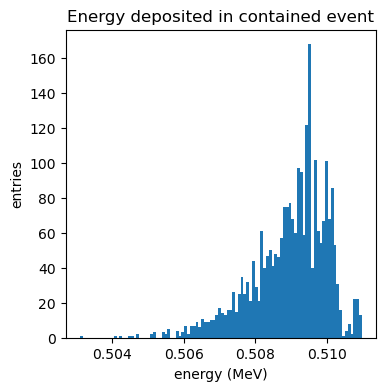

In [23]:
b, e = histoplot(event_ekin(gdf3), 'energy (MeV)', "entries", bins=100, figsize=(6,6),
                title="Energy deposited in contained event")

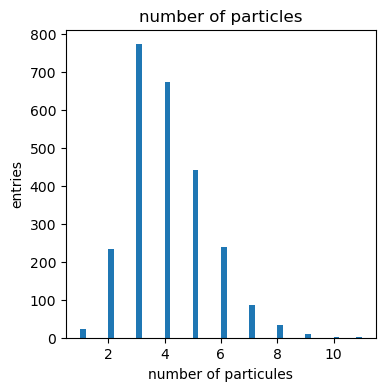

In [24]:
grdf = gdf3.groupby('event_id')
group_sizes = grdf.size()
b, e = histoplot(group_sizes, 'number of particules', "entries", bins=50, figsize=(4,4),
                title="number of particles")

## Impose threshold in energy and length

In [25]:
gdf4 = gdf3[(gdf3['kin_energy'] >eth) & (gdf3.length<lmax)]
gdf4.head(npr)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,initial_volume,final_volume,kin_energy,length,creator_proc
0,1,4,e-,0,1,-12.356936,-1.224260,23.614937,0.097969,-12.356945,-1.224278,23.614943,CRYSTAL,CRYSTAL,0.003540,0.000177,phot
1,1,3,gamma,0,1,-12.356936,-1.224260,23.614937,0.097969,-12.327125,-1.398317,23.596510,CRYSTAL,CRYSTAL,0.030979,0.177550,phot
2,1,2,e-,0,1,-12.356936,-1.224260,23.614937,0.097969,-12.290342,-1.233843,23.598602,CRYSTAL,CRYSTAL,0.475013,0.539498,phot
3,3,2,e-,0,1,-22.940617,-6.074331,25.743437,0.105827,-22.959177,-6.028592,25.752043,CRYSTAL,CRYSTAL,0.177790,0.123518,compt
4,3,17878,e-,0,1,-18.624298,-1.488481,29.427204,0.130164,-18.596409,-1.496239,29.408428,CRYSTAL,CRYSTAL,0.194258,0.150796,compt
5,3,37711,e-,0,1,-18.776112,-2.697741,30.735048,0.136127,-18.776150,-2.697742,30.735048,CRYSTAL,CRYSTAL,0.002757,0.000171,phot
6,3,37709,gamma,0,1,-18.776112,-2.697741,30.735048,0.136127,-18.705000,-2.698852,30.749388,CRYSTAL,CRYSTAL,0.028306,0.072552,phot
7,3,37708,e-,0,1,-18.776112,-2.697741,30.735048,0.136127,-18.771688,-2.690413,30.747807,CRYSTAL,CRYSTAL,0.104485,0.057776,phot
8,4,2,e-,0,1,-22.427443,22.119202,18.769426,0.083345,-22.428923,22.120600,18.769791,CRYSTAL,CRYSTAL,0.037430,0.005277,compt
9,4,3685,e-,0,1,-22.611578,21.608208,20.102449,0.088147,-22.629335,21.595926,20.238630,CRYSTAL,CRYSTAL,0.286827,0.260534,compt


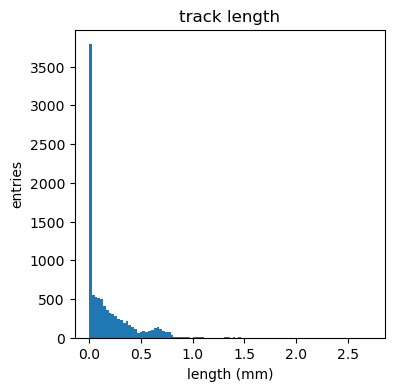

In [26]:
b, e = histoplot(gdf4.length, "length (mm)", "entries", bins=100, figsize=(4,4), title="track length")

### XYZ distributions

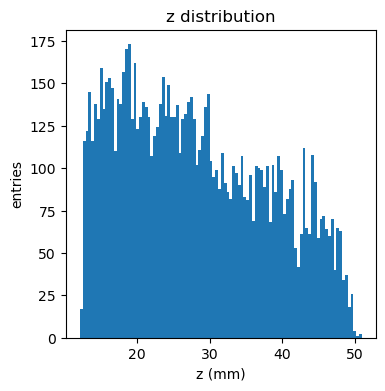

In [27]:
b, e = histoplot(gdf4.initial_z, "z (mm)", "entries", bins=100, figsize=(4,4),
                title="z distribution")

In [28]:
zmin = np.ceil(e[0])
zmax = np.floor(e[-1])
dz = zmax - zmin
print(f"zmax = {zmax:.2f}, zmin = {zmin:.2f}, dz = {dz:.2f}")

zmax = 50.00, zmin = 13.00, dz = 37.00


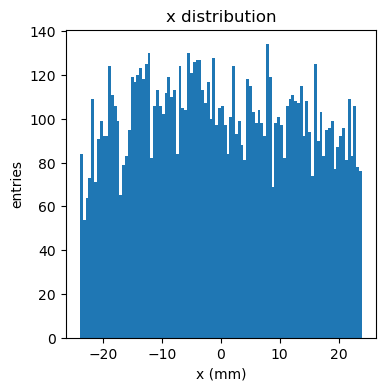

In [29]:
b, e = histoplot(gdf4.initial_x, "x (mm)", "entries", bins=100, figsize=(4,4),
                 title="x distribution")

In [30]:
xmin = -np.ceil(-e[0])
xmax = np.ceil(e[-1])
dx = xmax - xmin
print(f"xmax = {xmax:.2f}, xmin = {xmin:.2f}, dx = {dx:.2f}")

xmax = 24.00, xmin = -24.00, dx = 48.00


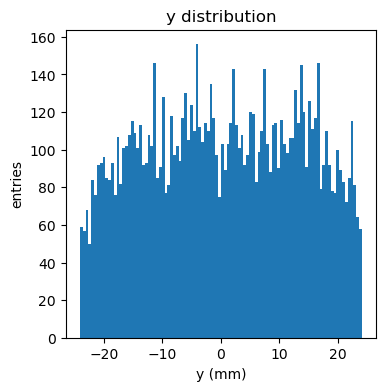

In [31]:
b, e = histoplot(gdf4.initial_y, "y (mm)", "entries", bins=100, figsize=(4,4),
                 title="y distribution")

In [32]:
ymin = -np.ceil(-e[0])
ymax = np.ceil(e[-1])
dy = ymax - ymin
print(f"ymax = {ymax:.2f}, ymin = {ymin:.2f}, dy = {dy:.2f}")

ymax = 25.00, ymin = -25.00, dy = 50.00


In [33]:
MCrst = namedtuple('MCrst','xmin xmax dx ymin ymax dy zmin zmax dz')
mcrst = MCrst(xmin, xmax, dx, ymin, ymax, dy, zmin, zmax, dz)
mcrst

MCrst(xmin=-24.0, xmax=24.0, dx=48.0, ymin=-25.0, ymax=25.0, dy=50.0, zmin=13.0, zmax=50.0, dz=37.0)

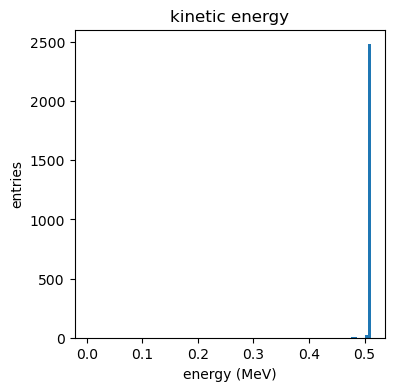

In [34]:
b, e = histoplot(event_ekin(gdf4), 'energy (MeV)', "entries", bins=100, figsize=(6,6),
                title="kinetic energy")

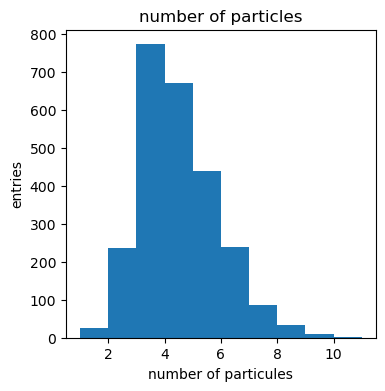

In [35]:
grdf = gdf4.groupby('event_id')
group_sizes = grdf.size()
b, e = histoplot(group_sizes, 'number of particules', "entries", bins=10, figsize=(4,4,),
                title="number of particles")

In [36]:
fce = event_size(gdf4)/event_size(gdf0)
print(f"Fraction of events contained in crystal = {(fce):.2f}")

Fraction of events contained in crystal = 0.65


In [37]:
gdf5 = gdf4.drop(['initial_x', 'initial_y', 'initial_z', 
                  'primary', 'mother_id', 'initial_volume', 'final_volume'], axis=1)
gdf5.head(npr)

,event_id,particle_id,particle_name,initial_t,final_x,final_y,final_z,kin_energy,length,creator_proc
0,1,4,e-,0.097969,-12.356945,-1.224278,23.614943,0.003540,0.000177,phot
1,1,3,gamma,0.097969,-12.327125,-1.398317,23.596510,0.030979,0.177550,phot
2,1,2,e-,0.097969,-12.290342,-1.233843,23.598602,0.475013,0.539498,phot
3,3,2,e-,0.105827,-22.959177,-6.028592,25.752043,0.177790,0.123518,compt
4,3,17878,e-,0.130164,-18.596409,-1.496239,29.408428,0.194258,0.150796,compt
5,3,37711,e-,0.136127,-18.776150,-2.697742,30.735048,0.002757,0.000171,phot
6,3,37709,gamma,0.136127,-18.705000,-2.698852,30.749388,0.028306,0.072552,phot
7,3,37708,e-,0.136127,-18.771688,-2.690413,30.747807,0.104485,0.057776,phot
8,4,2,e-,0.083345,-22.428923,22.120600,18.769791,0.037430,0.005277,compt
9,4,3685,e-,0.088147,-22.629335,21.595926,20.238630,0.286827,0.260534,compt


## Classification of events

### Select events in which the primary electron makes a photoelectric

In [38]:
grdf = gdf5.groupby('event_id')
gpe = grdf.filter(lambda x: ((x.particle_id == 2) & (x['creator_proc'] == 'phot')).any() )
gpe.head(npr)

,event_id,particle_id,particle_name,initial_t,final_x,final_y,final_z,kin_energy,length,creator_proc
0,1,4,e-,0.097969,-12.356945,-1.224278,23.614943,0.003540,0.000177,phot
1,1,3,gamma,0.097969,-12.327125,-1.398317,23.596510,0.030979,0.177550,phot
2,1,2,e-,0.097969,-12.290342,-1.233843,23.598602,0.475013,0.539498,phot
13,10,4,gamma,0.076319,21.778830,3.626679,16.771116,0.004273,0.002387,phot
14,10,3,gamma,0.076319,21.690163,3.330573,16.505219,0.030979,0.501098,phot
15,10,2,e-,0.076319,21.905153,3.560991,16.743124,0.475013,0.701540,phot
25,15,4,gamma,0.136076,8.783142,-17.274261,34.431221,0.003913,0.023425,phot
26,15,3,gamma,0.136076,8.442817,-17.217295,34.369698,0.028609,0.359010,phot
27,15,2,e-,0.136076,8.809553,-17.193239,34.423046,0.477824,0.354008,phot
51,21,4,e-,0.101080,-3.358141,8.090915,24.305965,0.004190,0.000383,phot


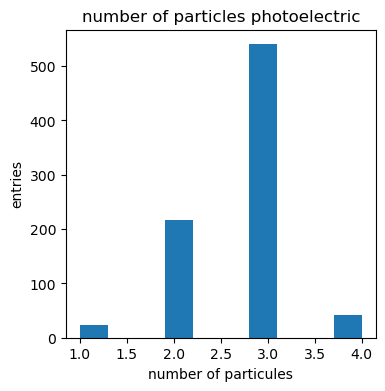

In [39]:
grdf = gpe.groupby('event_id')
group_sizes = grdf.size()
b, e = histoplot(group_sizes, 'number of particules', "entries", bins=10, figsize=(4,4),
                title="number of particles photoelectric")

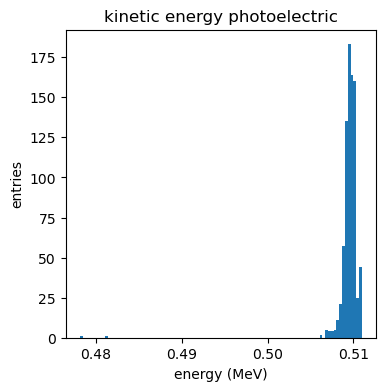

In [40]:
b, e = histoplot(event_ekin(gpe), 'energy (MeV)', "entries", bins=100, figsize=(4,4),
                title="kinetic energy photoelectric")

In [41]:
fphe = event_size(gpe)/event_size(gdf4)
print(f"Fraction of photoelectric events = {(fphe):.2f}")

Fraction of photoelectric events = 0.33


### Select Compton

In [42]:
grdf = gdf5.groupby('event_id')
gcomp = grdf.filter(lambda x: ((x.particle_id == 2) & (x['creator_proc'] == 'compt')).any() )
gcomp.head(npr)

,event_id,particle_id,particle_name,initial_t,final_x,final_y,final_z,kin_energy,length,creator_proc
3,3,2,e-,0.105827,-22.959177,-6.028592,25.752043,0.177790,0.123518,compt
4,3,17878,e-,0.130164,-18.596409,-1.496239,29.408428,0.194258,0.150796,compt
5,3,37711,e-,0.136127,-18.776150,-2.697742,30.735048,0.002757,0.000171,phot
6,3,37709,gamma,0.136127,-18.705000,-2.698852,30.749388,0.028306,0.072552,phot
7,3,37708,e-,0.136127,-18.771688,-2.690413,30.747807,0.104485,0.057776,phot
8,4,2,e-,0.083345,-22.428923,22.120600,18.769791,0.037430,0.005277,compt
9,4,3685,e-,0.088147,-22.629335,21.595926,20.238630,0.286827,0.260534,compt
10,4,32506,e-,0.097128,-23.931005,22.766010,18.060688,0.003282,0.000149,phot
11,4,32505,gamma,0.097128,-23.726477,22.638563,17.942863,0.030979,0.268251,phot
12,4,32504,e-,0.097128,-23.933041,22.810606,18.051018,0.149746,0.103043,phot


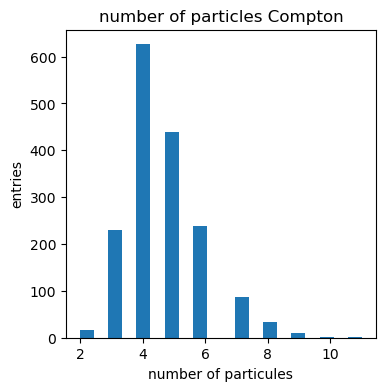

In [43]:
grdf = gcomp.groupby('event_id')
group_sizes = grdf.size()
b, e = histoplot(group_sizes, 'number of particules', "entries", bins=20, figsize=(4,4),
                title="number of particles Compton")

In [44]:
fcomp = event_size(gcomp)/event_size(gdf4)
print(f"Fraction of compton events = {(fcomp):.2f}")

Fraction of compton events = 0.67


### Copy dataframe for later

In [45]:
gdx = gdf5.copy(deep=True)
gdy = gdf5.copy(deep=True)

## Case of Pixelated crystal
- Slice x,y in cells corresponding to the size of detector elements (e.g, 3x3 or 6x6)
- no slice in z

### Select events (pixelated case)
- Conditions:
- Energy within 5 % of 511 keV
- 1 pixel lighted

In [46]:
emin = 0.511 - 0.05*0.511
print(f"minimum energy: emin ={emin:.3f}")

minimum energy: emin =0.485


### Comparison between 6x6 and 3x3

In [47]:
npxl3x3 = pixelated(gdy,mcrst,sx=3,sy=3,sz=dz, ecut=emin)

nx = 16, ny = 16, nz = 1
number of voxels = 256
index for xmin =0.0 index for xmax =16.0
index for ymin =0.0 index for ymax =16.0
index for zmin =0.0 index for zmax =1.0


In [48]:
fpxsel3x3 = npxl3x3/event_size(gdf0)
print(f"fraction of selected devents (wrt total events) pixelated 3x3 detector: {(fpxsel3x3):.2f}")

fraction of selected devents (wrt total events) pixelated 3x3 detector: 0.27


In [49]:
npxl6x6 = pixelated(gdy,mcrst,sx=6,sy=6,sz=dz,ecut=emin)

nx = 8, ny = 8, nz = 1
number of voxels = 64
index for xmin =0.0 index for xmax =8.0
index for ymin =0.0 index for ymax =8.0
index for zmin =0.0 index for zmax =1.0


In [50]:
fpxsel6x6 = npxl6x6/event_size(gdf0)
print(f"fraction of selected devents (wrt total events) pixelated 6x6 detector: {(fpxsel6x6):.2f}")

fraction of selected devents (wrt total events) pixelated 6x6 detector: 0.34


## The case of monolithic crystal

- slice in (x,y,z).
- take the size of the slice equal to that of SiPM (e.g, 6x6)

In [51]:
gdm = gdx.copy()

In [52]:
gdm = voxelize(gdm,mcrst,sx=6,sy=6,sz=6,ecut=emin, case='mono')

nx = 8, ny = 8, nz = 6
number of voxels = 384
index for xmin =0.0 index for xmax =8.0
index for ymin =0.0 index for ymax =8.0
index for zmin =0.0 index for zmax =6.0


In [53]:
gdm.head(npr)

,event_id,ix,iy,iz,ebox,tbox,xbox,ybox,zbox,nbox
0,1,1,3,1,0.509532,0.097969,-12.324803,-1.285479,23.603354,3
1,3,0,3,2,0.507597,0.128874,-19.561686,-3.122367,29.478542,5
2,4,0,7,0,0.221437,0.093682,-23.504862,22.583944,18.206089,4
3,4,0,7,1,0.286827,0.088147,-22.629335,21.595926,20.238630,1
4,10,7,4,0,0.510265,0.076319,21.791382,3.506081,16.673153,3
5,12,0,1,0,0.196762,0.072497,-21.746677,-17.568899,15.576235,1
6,12,1,2,0,0.313091,0.101944,-15.359886,-12.358227,18.806292,2
7,14,5,7,0,0.100251,0.083498,9.263078,20.982071,18.952204,3
8,14,7,7,3,0.376061,0.148073,21.183729,22.991249,34.159786,1
9,14,7,8,3,0.031653,0.148073,21.178696,23.115894,33.863358,2


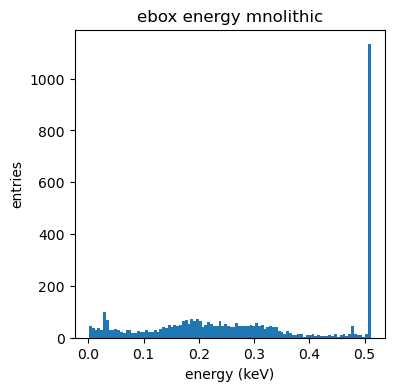

In [54]:
b, e = histoplot(gdm.ebox, "energy (keV)", "entries", bins=100, figsize=(4,4),
                title="ebox energy mnolithic")

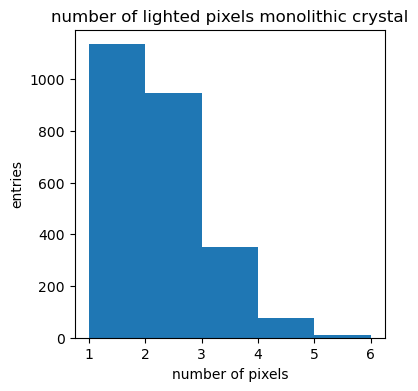

In [55]:
evts, evts_size = np.unique(gdm.event_id.values, return_counts=True)
b, e = histoplot(evts_size, "number of pixels", "entries", bins=5, figsize=(4,4),
                title="number of lighted pixels monolithic crystal") 

In [56]:
f1c = b[0]/np.sum(b)
f2c = b[1]/np.sum(b)
f3c = b[2]/np.sum(b)
print(f"fractions: 1 cluster ={f1c:.2f}")
print(f"fractions: 2 cluster ={f2c:.2f}")
print(f"fractions: 3 cluster ={f3c:.2f}")

fractions: 1 cluster =0.45
fractions: 2 cluster =0.38
fractions: 3 cluster =0.14


## Split data into three streams.
- Stream 1g: events with 1 cluster: true information: x,y,z,t,e
- Stream 2g: events with 2 clusters: true information: x1,y1,z1,t1,e1, x2,y2,z2,t2,e2
- Stream ng: events with more than 2 clusters: no true information needed

#### Strategy:
- First classify events as 1g, 2g or ng. This requires training a CNN with events of categories 1g, 2g, ng.
- Output of the net decides type of event.
- if 1g pass event through a second net trained with events of type 1g and find x,y,z.
- if 2g pass event through a second net trained with events of type 2g and find (x,y,z)_1,2
- if ng reject event

In [57]:
event_size(gdm)/event_size(gdf0)

0.6456248396202207

In [58]:
df1g,df2g,dfng = streams(gdm)

 fraction of events 1g = 0.45
 fraction of events 2g = 0.38
 fraction of events >3g = 0.17


In [59]:
gdmx = gdm.drop(['ix', 'iy', 'iz', 
                  'tbox', 'nbox'], axis=1)
gdmx.head(npr)

,event_id,ebox,xbox,ybox,zbox
0,1,0.509532,-12.324803,-1.285479,23.603354
1,3,0.507597,-19.561686,-3.122367,29.478542
2,4,0.221437,-23.504862,22.583944,18.206089
3,4,0.286827,-22.629335,21.595926,20.238630
4,10,0.510265,21.791382,3.506081,16.673153
5,12,0.196762,-21.746677,-17.568899,15.576235
6,12,0.313091,-15.359886,-12.358227,18.806292
7,14,0.100251,9.263078,20.982071,18.952204
8,14,0.376061,21.183729,22.991249,34.159786
9,14,0.031653,21.178696,23.115894,33.863358


In [60]:
gdm1c = gdmx[gdmx['event_id'].isin(df1g.event_id.values)]
gdm1c.head(npr)

,event_id,ebox,xbox,ybox,zbox
0,1,0.509532,-12.324803,-1.285479,23.603354
1,3,0.507597,-19.561686,-3.122367,29.478542
4,10,0.510265,21.791382,3.506081,16.673153
10,15,0.510347,8.678504,-17.228266,34.407990
23,21,0.510182,-3.393924,8.214833,24.242899
26,24,0.509780,17.817398,-8.478578,44.687397
36,31,0.510058,6.334840,18.033068,19.449629
42,34,0.509274,13.018387,15.764901,46.338161
45,36,0.509532,-18.509888,-15.362767,43.620972
69,54,0.510118,-4.917354,-10.481607,16.285175


In [61]:
gdm2c = gdmx[gdmx['event_id'].isin(df2g.event_id.values)]
gdm2c.head(npr)

,event_id,ebox,xbox,ybox,zbox
2,4,0.221437,-23.504862,22.583944,18.206089
3,4,0.286827,-22.629335,21.595926,20.238630
5,12,0.196762,-21.746677,-17.568899,15.576235
6,12,0.313091,-15.359886,-12.358227,18.806292
24,22,0.213324,17.179495,-1.924621,14.857929
25,22,0.295461,17.948851,1.561837,16.291643
27,25,0.317640,-15.019795,-1.242328,22.377869
28,25,0.192617,-10.413887,2.409485,17.253313
29,26,0.419663,2.998995,13.721797,39.855122
30,26,0.090147,7.904878,13.587720,35.437347


In [62]:
gdmnc = gdmx[gdmx['event_id'].isin(dfng.event_id.values)]
gdmnc.head(npr)

,event_id,ebox,xbox,ybox,zbox
7,14,0.100251,9.263078,20.982071,18.952204
8,14,0.376061,21.183729,22.991249,34.159786
9,14,0.031653,21.178696,23.115894,33.863358
11,17,0.077242,4.407759,15.842754,21.856821
12,17,0.340380,4.157046,19.497139,17.763126
13,17,0.088952,5.802333,17.565784,20.993097
14,18,0.019191,-8.136803,-21.031120,18.813810
15,18,0.183522,-9.532592,-18.319399,15.451363
16,18,0.303661,-7.895463,-14.359824,27.261036
17,19,0.434288,-0.698718,-0.484844,45.347191


## Two cluster case

In [63]:
grdf = gdm2c.groupby('event_id')
gdy2ca = grdf.agg(#event_id = ('event_id', 'first'),
                etot = ('ebox', 'sum'),
                e1 = ('ebox', 'first'),
                e2 = ('ebox', 'last'),
                x1 = ('xbox', 'first'),
                x2 = ('xbox', 'last'),
                y1 = ('ybox', 'first'),
                y2 = ('ybox', 'last'),
                z1 = ('zbox', 'first'),
                z2 = ('zbox', 'last')
                  ).reset_index()

In [64]:
gdy2ca

,event_id,etot,e1,e2,x1,x2,y1,y2,z1,z2
0,4,0.508264,0.221437,0.286827,-23.504862,-22.629335,22.583944,21.595926,18.206089,20.238630
1,12,0.509853,0.196762,0.313091,-21.746677,-15.359886,-17.568899,-12.358227,15.576235,18.806292
2,22,0.508785,0.213324,0.295461,17.179495,17.948851,-1.924621,1.561837,14.857929,16.291643
3,25,0.510257,0.317640,0.192617,-15.019795,-10.413887,-1.242328,2.409485,22.377869,17.253313
4,26,0.509810,0.419663,0.090147,2.998995,7.904878,13.721797,13.587720,39.855122,35.437347
...,...,...,...,...,...,...,...,...,...,...
940,3872,0.507010,0.342214,0.164796,-9.737653,-7.078852,13.152273,11.693000,16.883734,23.722748
941,3882,0.509562,0.028609,0.480952,4.645298,4.556379,-19.103146,-18.647085,12.618118,13.483722
942,3889,0.508052,0.029236,0.478816,-11.660211,-10.561278,1.886710,5.158408,27.451233,36.165478
943,3891,0.509356,0.216075,0.293281,-21.633266,-19.607063,-21.228594,-13.773992,17.996925,19.961136


Text(0, 0.5, 'e2 (mm)')

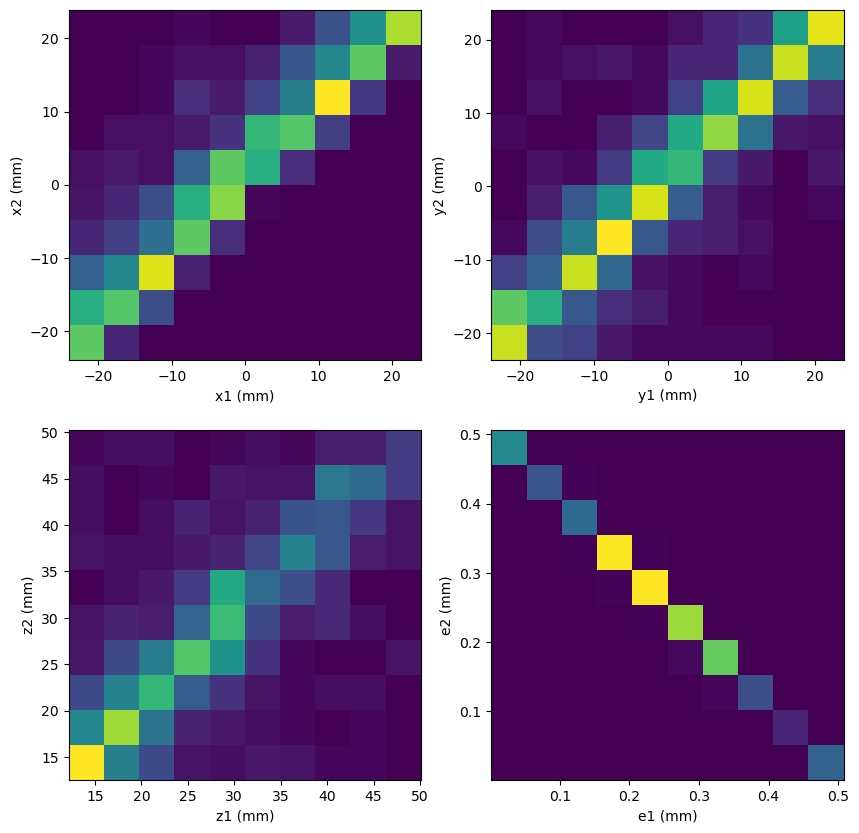

In [65]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))

hxy =ax[0,0].hist2d(gdy2ca.x1, gdy2ca.x2, cmap="viridis",bins=10)
#ax[0].set_aspect('equal')
ax[0,0].set_xlabel('x1 (mm)')
ax[0,0].set_ylabel('x2 (mm)')

hxz =ax[0,1].hist2d(gdy2ca.y1, gdy2ca.y2, cmap="viridis",bins=10)
#ax[1].set_aspect('equal')
ax[0,1].set_xlabel('y1 (mm)')
ax[0,1].set_ylabel('y2 (mm)')

hxz =ax[1,0].hist2d(gdy2ca.z1, gdy2ca.z2, cmap="viridis",bins=10)
#ax[1].set_aspect('equal')
ax[1,0].set_xlabel('z1 (mm)')
ax[1,0].set_ylabel('z2 (mm)')

hxz =ax[1,1].hist2d(gdy2ca.e1, gdy2ca.e2, cmap="viridis",bins=10)
#ax[1].set_aspect('equal')
ax[1,1].set_xlabel('e1 (mm)')
ax[1,1].set_ylabel('e2 (mm)')